# Write Here your Experiment Title

## Data Loading and Preprocessing

### Load required libraries and specify the data folder

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

data_folder = "\\\\izbkingston.izb.unibe.ch\\imaging.data\\mic01-imaging\\Alex\\pymmcore"
experiment_name = "TestJungfrau"
exp_path = os.path.join(data_folder, experiment_name)


### Load analysed data from rtm-pymmcore experiment

This loads the data from the individual field of views and create one big dataframe. This dataframe is then saved in your local folder and used to plot the data.

In [2]:
track_folder = "tracks" 
fovs = os.listdir(os.path.join(exp_path, track_folder))
fovs.sort()
dfs = []
for fov in fovs:
    track_file = os.path.join(exp_path, track_folder, fov)
    df = pd.read_parquet(track_file)
    dfs.append(df)
df = pd.concat(dfs)
df.to_parquet("data.parquet")

In [3]:
df['fname'] = df.apply(lambda row: f"{int(row['fov']):03d}_{int(row['frame']):05d}", axis=1)
df.to_parquet(os.path.join(exp_path, "exp_data.parquet"))

### Data clean-up
Add Cytoplasma to nuclear ratio based on measured intensities. Further normalise according to the first few frames. Remove cells which were not tracked for 80% of the frames.

In [4]:

df = pd.read_parquet("data.parquet")
df["cnr"] = df["mean_intensity_C1_ring"] / df["mean_intensity_C1_nuc"]
df["uid"] = df["fov"].astype("string") + "_" + df["particle"].astype("string")

frame_counts = df["uid"].value_counts()
threshold = 0.9 * frame_counts.max()

valid_uids = frame_counts[frame_counts >= threshold].index
df = df[df["uid"].isin(valid_uids)]

In [5]:
mean_cnr_first_four_frames = df[df['frame'] < 10].groupby('uid')['cnr'].mean()
df['cnr_norm'] = df.apply(lambda row: row['cnr'] / mean_cnr_first_four_frames[row['uid']], axis=1)

In [40]:
# A quick way to look at your data is plotly express
# plot = px.line(df.query("stim_exposure == 100.0"), x="frame", y="cnr", color="uid")
# plot.add_vline(x=5, line_dash="dot", line_color="red")

## Results

### Raw CnR data

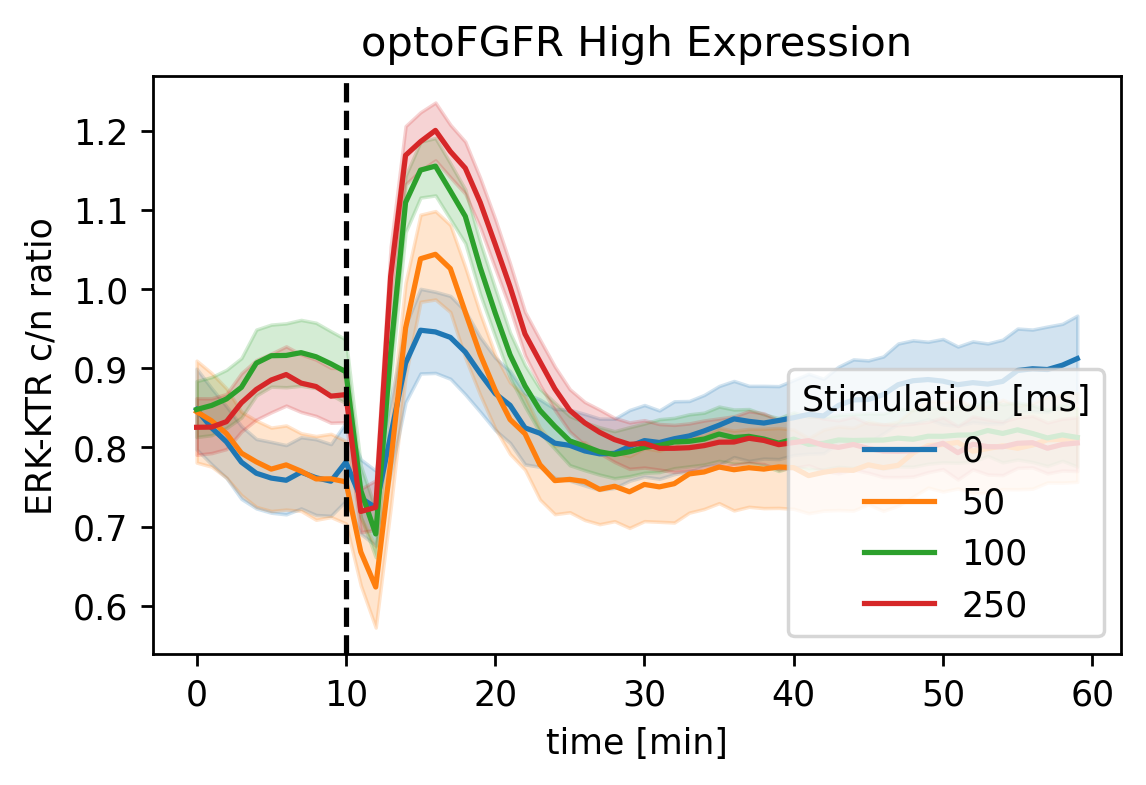

In [7]:
plt.figure(figsize=(5, 3),dpi = 250)
df["stim_exposure"] = df["stim_exposure"].astype("int")
sns.lineplot(data=df, x='frame', y='cnr', hue="stim_exposure", palette="tab10", errorbar=('ci',90))
plt.legend(loc='lower right', title='Stimulation [ms]')
plt.ylabel('ERK-KTR c/n ratio')
plt.xlabel('time [min]')
plt.axvline(x=10, color='black', linestyle='--')
plt.title("optoFGFR High Expression")
plt.savefig("ERK-KTR_cnr.svg", bbox_inches='tight')
plt.show()

### Normalised CnR data

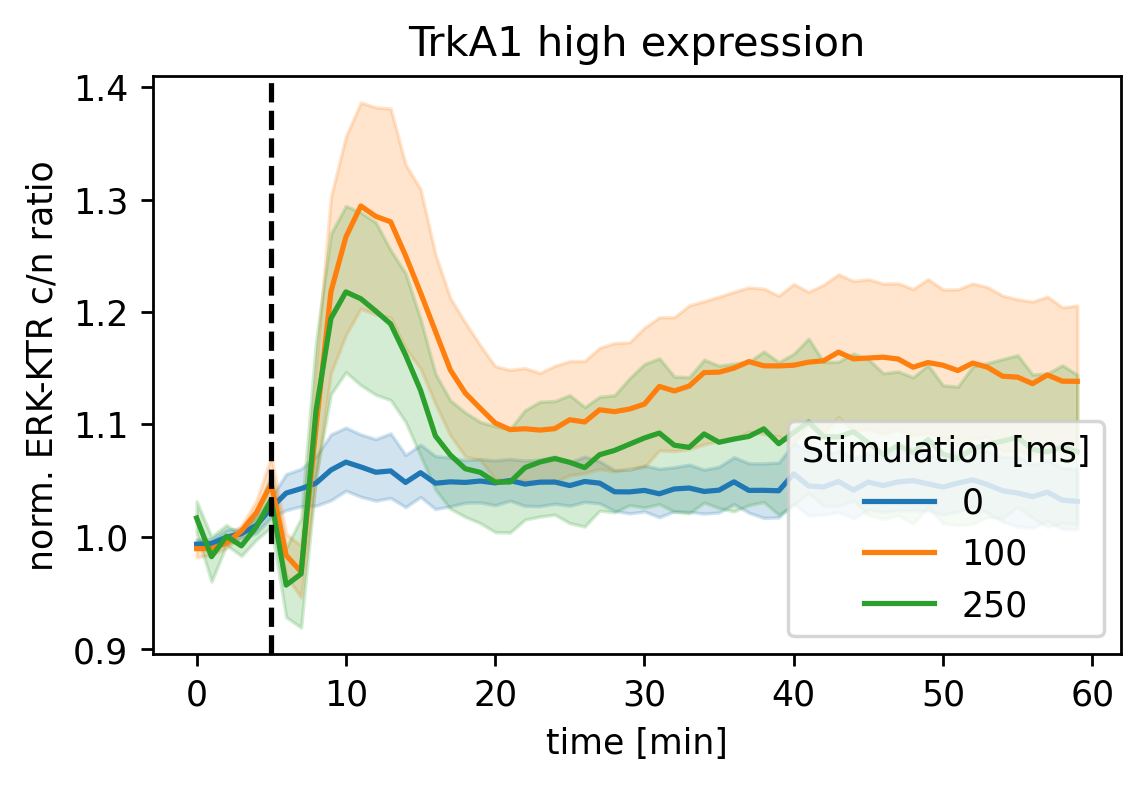

In [14]:
plt.figure(figsize=(5, 3),dpi = 250)
df["stim_exposure"] = df["stim_exposure"].astype("int")
sns.lineplot(data=df, x='frame', y='cnr_norm', hue="stim_exposure", palette="tab10", errorbar=('ci',90))
plt.legend(loc='lower right', title='Stimulation [ms]')
plt.ylabel('norm. ERK-KTR c/n ratio')
plt.xlabel('time [min]')
plt.axvline(x=5, color='black', linestyle='--')
plt.title("TrkA1 high expression")
plt.savefig("ERK-KTR_cnr_norm.svg", bbox_inches='tight')
plt.show()